# Analysis of the Barcelona property market

The script visualizes the property market in Barcelona and identifies the good investment. The data is stored in './data/data.csv' and was obtained using the script 'Idealista API'.

*Author: Mislav Jordanić*

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import neighbors

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

df_original = pd.read_csv('./data/data.csv')
df=df_original.copy()

## Organize data

In [2]:
# Remove unnecesarry columns
df = df[['propertyCode', 'floor', 'price', 'propertyType', 'size',
       'exterior', 'rooms', 'bathrooms', 'district', 'neighborhood', 'latitude',
       'longitude', 'priceByArea', 'status', 'hasLift', 'Week']]

df['propertyCode'] = pd.to_numeric(df['propertyCode'], errors='coerce') 
df['propertyType'] = df['propertyType'].astype('category')
df['district'] = df['district'].astype('category')
df['neighborhood'] = df['neighborhood'].astype('category')
df['status'] = df['status'].astype('category')
df['floor'] = df['floor'].astype('str')
# drop identical rows (keep only the first instance)
df.drop_duplicates(inplace=True)

df.reset_index(drop=True, inplace=True)
df.head(5)


propertyCode floor     price propertyType  size  exterior  rooms  \
0      87688139     3  172000.0         flat  67.0     False      2   
1      89127122     2  130000.0         flat  32.0      True      1   
2      89115559     1  149000.0         flat  45.0     False      2   
3      89102591     5  220000.0         flat  54.0      True      2   
4      89123676    bj  103000.0         flat  67.0     False      2   

   bathrooms      district                       neighborhood   latitude  \
0          2      Eixample    L'Antiga Esquerra de l'Eixample  41.387739   
1          1  Ciutat Vella                           El Raval  41.380189   
2          1    Nou Barris                              Porta  41.430582   
3          1      Eixample                 La Sagrada Família  41.410451   
4          1    Nou Barris  Can Peguera - El Turó de la Peira  41.432788   

   longitude  priceByArea status hasLift  Week  
0   2.151873       2567.0    NaN     NaN    14  
1   2.165333       4063.0   good   False    14  
2   2.177449       3311.0   good    True    14  
3   2.178700       4074.0   good    True    14  
4   2.169198       1537.0  renew    True    14

## Analyze Duplicates

### Generate index of repeated adds
The index of all properties is generated. Repeated properties have the same index.

E.g. if the following array is given:
(1,2,4,1,5,6,4,1,7,9),

'duplicatesIndex' will have values:
(0,1,2,0,3,4,2,0,5,6)

TODO: The function get_duplicates uses 2 for loops and it's very ineficient! 

In [3]:
%%time
def get_duplicates(dup, sizeDifference=1, latitudeDifference=0.001, longitudeDifference=0.001, priceByAreaDifference=600):
    sizes = dup['size'].values
    latitude = dup['latitude'].values
    longitude = dup['longitude'].values
    priceByArea = dup['priceByArea'].values
    rooms = dup['rooms'].values
    bathrooms = dup['bathrooms'].values
    properties = dup['propertyType'].values
    floor = dup['floor'].values

    rez = np.zeros(dup.shape[0],)
    rez[:] = np.nan

    for index in range(rez.size):
        sz = sizes[index]
        la = latitude[index]
        lo = longitude[index]
        pi = priceByArea[index]
        ro = rooms[index]
        ba = bathrooms[index]
        pr = properties[index]
        fl = floor[index]

        for index2 in range(index, rez.size):
            sz2 = sizes[index2]
            la2 = latitude[index2]
            lo2 = longitude[index2]
            pi2 = priceByArea[index2]
            ro2 = rooms[index2]
            ba2 = bathrooms[index2]
            pr2 = properties[index2]
            fl2 = floor[index2]

            duplicate_flag = np.all(((np.abs(sz-sz2) < sizeDifference), 
                                     (np.abs(la-la2) < latitudeDifference), 
                                     (np.abs(lo-lo2) < longitudeDifference), 
                                     (np.abs(pi-pi2) < priceByAreaDifference), 
                                     (ro == ro2), (ba == ba2), (pr == pr2), (fl == fl2)))

            # print(index, index2)
            if (np.isnan(rez[index2])) & duplicate_flag:
                rez[index2]=index
    return rez

dup=df.copy().reset_index(drop=True)
duplicatesIndex=get_duplicates(dup)

CPU times: user 3min 36s, sys: 44.1 ms, total: 3min 36s
Wall time: 3min 36s


### Remove duplicates
This cell removes the duplicates by grouping them by 'duplicatesIndex' column.
It also generates new columns with minimum and maximum prices extracted from repeated adds and week of first occurence and last occurence of an add.
Moreover, columns with absolute price difference and relative price difference in percentage are extracted.

Dataframe 'df' contains the data with removed duplicates, whereas dataframe 'dup' contains the data with all adds (without removing the duplicates). Dataframe 'df' is used in the further analysis.

In [4]:
dup['duplicatesIndex'] = duplicatesIndex.astype(int)
dup['duplicates'] = dup.duplicated(subset=['duplicatesIndex'], keep=False)
df = dup.drop_duplicates(subset=['duplicatesIndex'], keep='last')

group_dup = dup.groupby(['duplicatesIndex'])[[
    'price', 'priceByArea', 'Week']].agg(['count', 'min', 'max'])

group_dup.columns = ['dupPriceCount', 'dupPriceMin', 'dupPriceMax', 
                     'dupPriceByAreaCount','dupPriceByAreaMin', 'dupPriceByAreaMax', 
                     'dupWeekCount', 'dupWeekMin', 'dupWeekMax']
group_dup = group_dup[['dupPriceCount', 'dupPriceMin', 'dupPriceMax', 
                     'dupPriceByAreaMin', 'dupPriceByAreaMax', 
                     'dupWeekMin', 'dupWeekMax']]
group_dup.rename(columns={"dupPriceCount": "duplicatesCount"}, errors="raise", inplace=True)

df = df.join(group_dup, on='duplicatesIndex').reset_index(drop=True)

df['dupPriceDifference'] = (df['dupPriceMax'] - df['dupPriceMin'])
df['dupPriceDifference%'] = 100 * (df['dupPriceDifference'] / df[('dupPriceMax')])

There are 3453 renewes adds without change in price (96.24%)


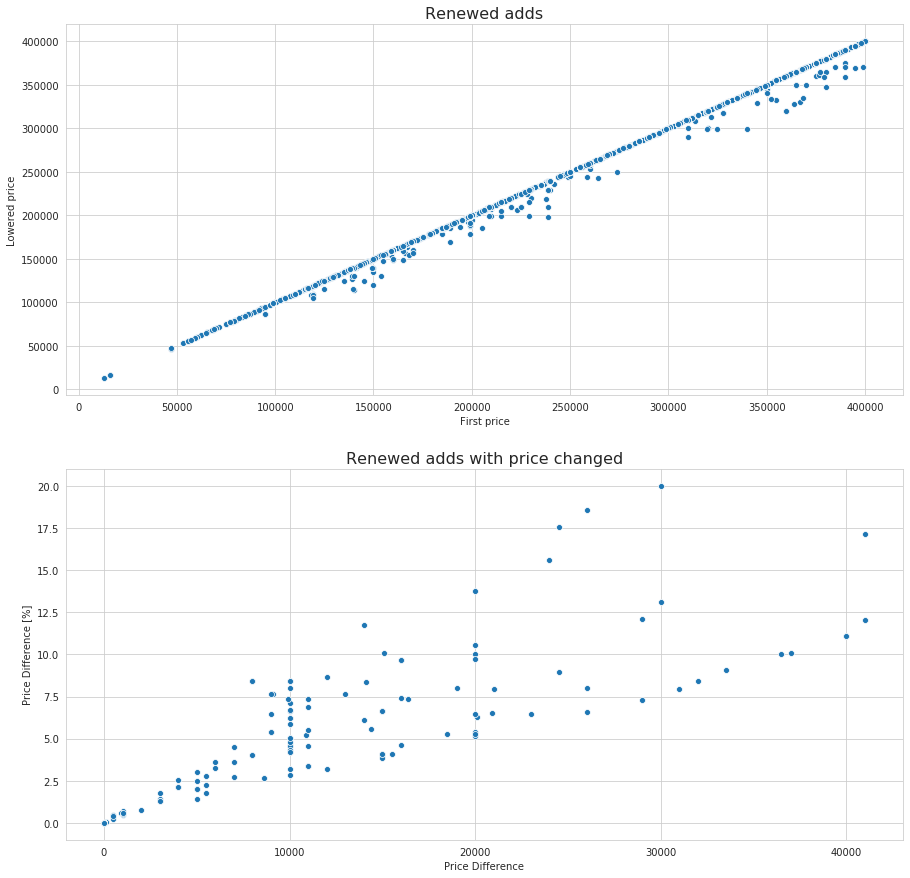

In [5]:
fig_size = (15, 15)
fig, ax = plt.subplots(2, figsize=fig_size)
df.propertyCode = df.propertyCode.astype(str)
sns.scatterplot(y='dupPriceMin', x='dupPriceMax', data=df, ax=ax[0])
ax[0].set_title('Renewed adds', fontsize=16)
ax[0].set_xlabel('First price')
ax[0].set_ylabel('Lowered price')

sns.scatterplot(x='dupPriceDifference', y='dupPriceDifference%', data=df, ax=ax[1])
ax[1].set_title('Renewed adds with price changed', fontsize=16)
ax[1].set_xlabel('Price Difference')
ax[1].set_ylabel('Price Difference [%]')

changed_price = ((df['dupPriceMin'] - df['dupPriceMax']) == 0).sum()
percent_changed_price = 100 * changed_price / df.shape[0]
print('There are {} renewes adds without change in price ({:.2f}%)'.format(
    changed_price, percent_changed_price))

In [6]:
df.describe()

price           size        rooms    bathrooms     latitude  \
count    3588.000000    3588.000000  3588.000000  3588.000000  3588.000000   
mean   239222.038462     105.727035     2.602564     1.219064    41.394716   
std     88517.575279    1918.774783     0.923511     0.429539     0.023742   
min     12900.000000      11.000000     0.000000     0.000000    41.348364   
25%    169000.000000      60.000000     2.000000     1.000000    41.373789   
50%    229500.000000      72.000000     3.000000     1.000000    41.389770   
75%    311250.000000      85.000000     3.000000     1.000000    41.415127   
max    400000.000000  115000.000000     6.000000     3.000000    41.449543   

         longitude   priceByArea         Week  duplicatesIndex  \
count  3588.000000   3588.000000  3588.000000      3588.000000   
mean      2.160011   3319.786511    18.511706      2218.891862   
std       0.030806   1139.574296     2.266501      1339.991247   
min       2.083150      1.000000    14.000000         0.000000   
25%       2.137123   2512.750000    17.000000      1011.750000   
50%       2.166334   3226.000000    19.000000      2289.000000   
75%       2.182057   3973.000000    20.000000      3386.500000   
max       2.227291  20818.000000    21.000000      4525.000000   

       duplicatesCount    dupPriceMin    dupPriceMax  dupPriceByAreaMin  \
count      3588.000000    3588.000000    3588.000000        3588.000000   
mean          1.261706  239164.233278  239644.614270        3318.867336   
std           0.703105   88521.326637   88593.066805        1139.322809   
min           1.000000   12900.000000   12900.000000           1.000000   
25%           1.000000  169000.000000  169000.000000        2512.000000   
50%           1.000000  229500.000000  230000.000000        3223.500000   
75%           1.000000  311000.000000  312375.000000        3973.000000   
max          19.000000  400000.000000  400000.000000       20818.000000   

       dupPriceByAreaMax   dupWeekMin   dupWeekMax  dupPriceDifference  \
count        3588.000000  3588.000000  3588.000000         3588.000000   
mean         3325.693144    18.137960    18.511706          480.380992   
std          1140.100929     2.376396     2.266501         3078.436894   
min             1.000000    14.000000    14.000000            0.000000   
25%          2517.000000    16.000000    17.000000            0.000000   
50%          3232.000000    19.000000    19.000000            0.000000   
75%          3980.000000    20.000000    20.000000            0.000000   
max         20818.000000    21.000000    21.000000        41000.000000   

       dupPriceDifference%  
count          3588.000000  
mean              0.210945  
std               1.323439  
min               0.000000  
25%               0.000000  
50%               0.000000  
75%               0.000000  
max              20.000000

In [7]:
# Remove propertise with surface area bigger than 150m2 or price higher than 6000 euros/m2
df=df.loc[df['size'] < 150]
df = df[df['priceByArea'] < 6000]
df.reset_index(drop=True, inplace=True)

In [8]:
# Show basic info of each column and number of NaNs

print('Info')
print(df.info())

print('\n\nNull Elements')
print(df.isnull().sum())

Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   propertyCode         3486 non-null   object  
 1   floor                3486 non-null   object  
 2   price                3486 non-null   float64 
 3   propertyType         3486 non-null   category
 4   size                 3486 non-null   float64 
 5   exterior             3486 non-null   bool    
 6   rooms                3486 non-null   int64   
 7   bathrooms            3486 non-null   int64   
 8   district             3420 non-null   category
 9   neighborhood         3414 non-null   category
 10  latitude             3486 non-null   float64 
 11  longitude            3486 non-null   float64 
 12  priceByArea          3486 non-null   float64 
 13  status               3160 non-null   category
 14  hasLift              3357 non-null   object  
 15  Week            

## Impute missing district and neighborhood
Impute missing district and neighborhood based on kNN and geolocation (latitude, longitude)

In [9]:
print('\n\n There are '+ repr(df.district.isnull().sum()) +' Null Elements in district to be imputed.')

index_missing = df.index[df.district.isnull()]

X = df.dropna(subset=['district']).loc[:,['latitude', 'longitude']]
y= df.dropna(subset =['district']).loc[:,'district']
assert X.shape[0]==y.shape[0], 'Dimensions do not match!'
model = neighbors.KNeighborsClassifier(2, weights='distance')
## Evaluate a knn model on the dataset using k-fold cross validation
# kfold = KFold(n_splits=3, random_state=7)
# result = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
# print(result.mean())
model.fit(X,y)
df.loc[index_missing, 'district'] = model.predict(X=df.loc[index_missing,['latitude', 'longitude']])



 There are 66 Null Elements in district to be imputed.


In [10]:
print('\n\n There are '+ repr(df.neighborhood.isnull().sum()) +' Null Elements in neighborhood to be imputed.')

index_missing = df.index[df.neighborhood.isnull()]

X = df.dropna(subset=['neighborhood']).loc[:,['latitude', 'longitude']]
y= df.dropna(subset =['neighborhood']).loc[:,'neighborhood']
assert X.shape[0]==y.shape[0], 'Dimensions do not match!'
model = neighbors.KNeighborsClassifier(2, weights='distance')
## evaluate a knn model on the dataset using k-fold cross validation
# kfold = KFold(n_splits=3, random_state=7)
# result = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
# print(result.mean())
model.fit(X,y)
df.loc[index_missing, 'neighborhood'] = model.predict(X=df.loc[index_missing,['latitude', 'longitude']])



 There are 72 Null Elements in neighborhood to be imputed.


## Analyze property types

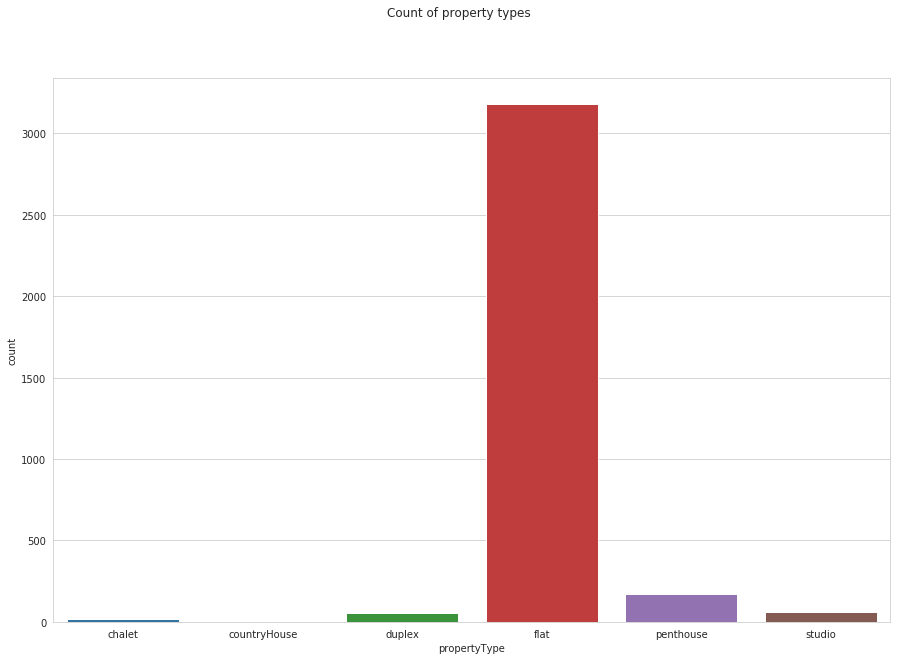

In [11]:
fig_size = (15,10)
fig, ax = plt.subplots(1,figsize=fig_size)
sns.countplot(x='propertyType', data=df, ax=ax);
fig.suptitle('Count of property types');

### Check distribution of Price, Size, and Price by Area

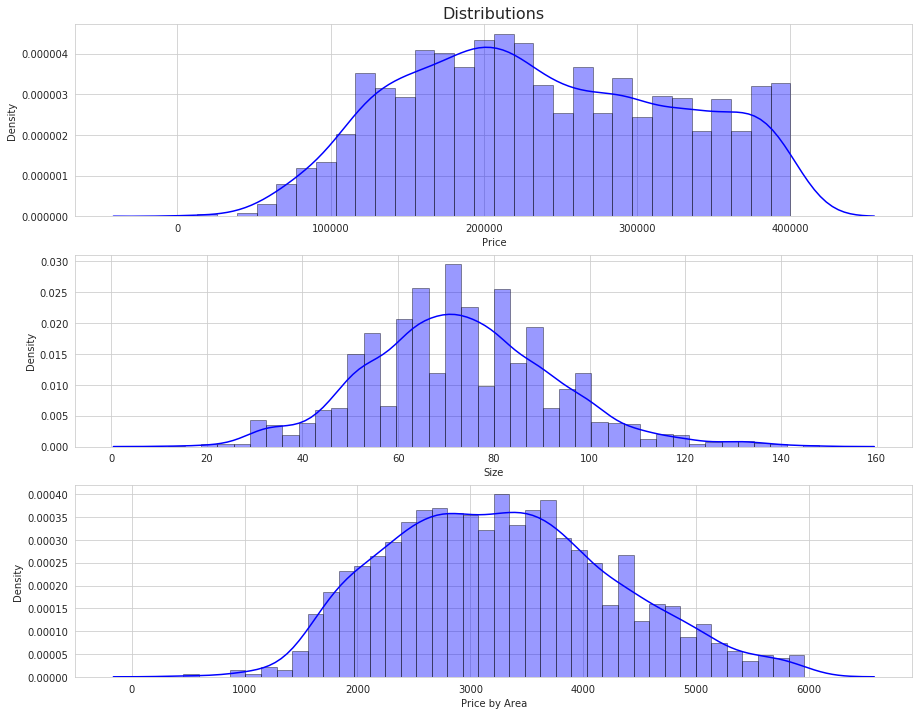

In [12]:
# Prices over 400k are exluded when requesting info from Idealista
fig_size = (15,12)
fig, ax = plt.subplots(3,figsize=fig_size)

sns.distplot(df['price'], hist=True, kde=True, 
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax = ax[0])
ax[0].set_title('Distributions', fontsize=16);
ax[0].set_xlabel('Price');
ax[0].set_ylabel('Density');


sns.distplot(df['size'], hist=True, 
             bins=40, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax = ax[1])
ax[1].set_xlabel('Size');
ax[1].set_ylabel('Density');


sns.distplot(df['priceByArea'], hist=True, kde=True, 
             bins=40, color = 'blue',
             hist_kws={'edgecolor':'black'}, ax = ax[2])
ax[2].set_xlabel('Price by Area');
ax[2].set_ylabel('Density');


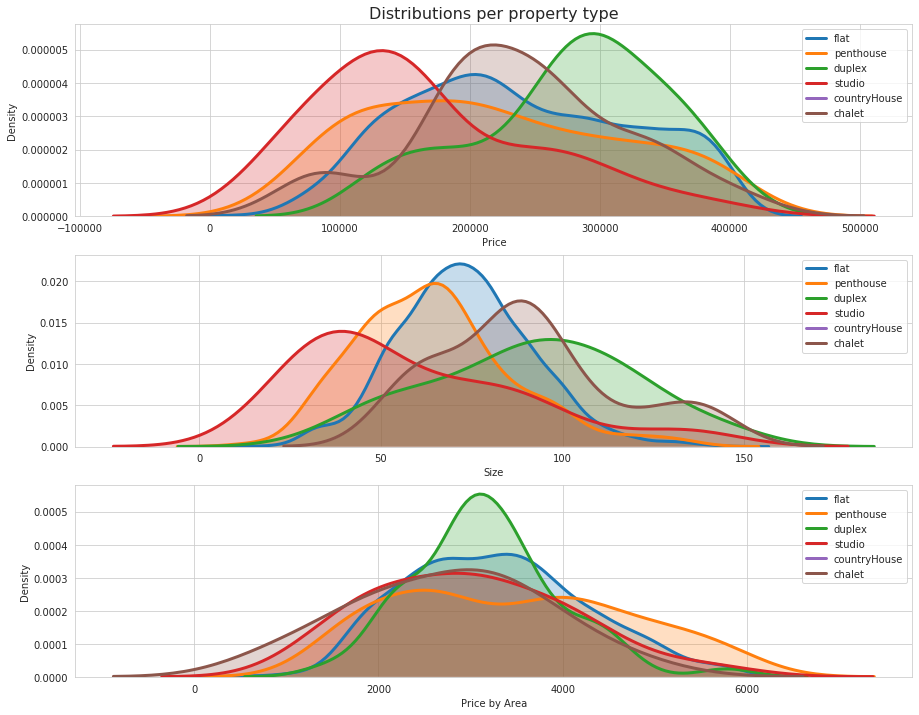

In [13]:
# Check for each type of property

fig_size = (15,12)
fig, ax = plt.subplots(3,figsize=fig_size)

for typeOfProperty in df.propertyType.unique():
    dfDist = df.loc[df['propertyType']==typeOfProperty, ['price', 'size', 'priceByArea']]
    
    sns.distplot(dfDist['price'], hist=False, kde=True, 
             kde_kws = {'shade': True, 'linewidth': 3},
                 label = typeOfProperty, ax = ax[0])
    
    sns.distplot(dfDist['size'], hist=False, kde=True,
             kde_kws = {'shade': True, 'linewidth': 3},
                 label = typeOfProperty, ax = ax[1])
    
    sns.distplot(dfDist['priceByArea'], hist=False, kde=True, 
             kde_kws = {'shade': True, 'linewidth': 3},
                 label = typeOfProperty, ax = ax[2])
    
# Add labels
ax[0].set_title('Distributions per property type', fontsize=16);
ax[0].set_xlabel('Price');
ax[0].set_ylabel('Density');

ax[1].set_xlabel('Size');
ax[1].set_ylabel('Density');

ax[2].set_xlabel('Price by Area');
ax[2].set_ylabel('Density');
    
    

### Scatter plot of Price by Area vs. Size for each property type

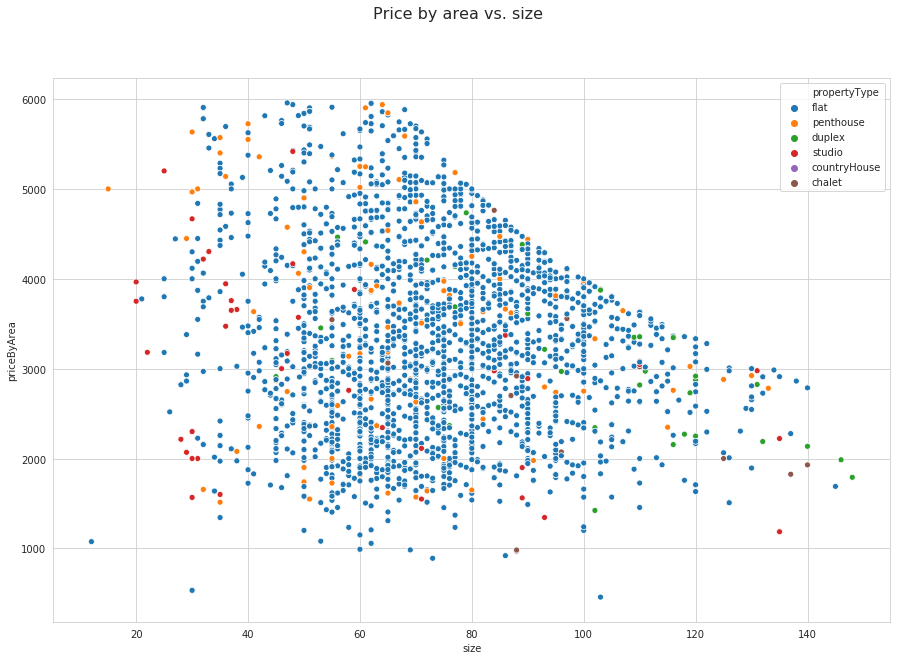

In [14]:
fig_size = (15,10)
fig, ax = plt.subplots(figsize=fig_size)
sns.scatterplot(y='priceByArea', x='size', hue='propertyType', data=df, ax=ax)
fig.suptitle('Price by area vs. size', fontsize=16);


### Number of rooms

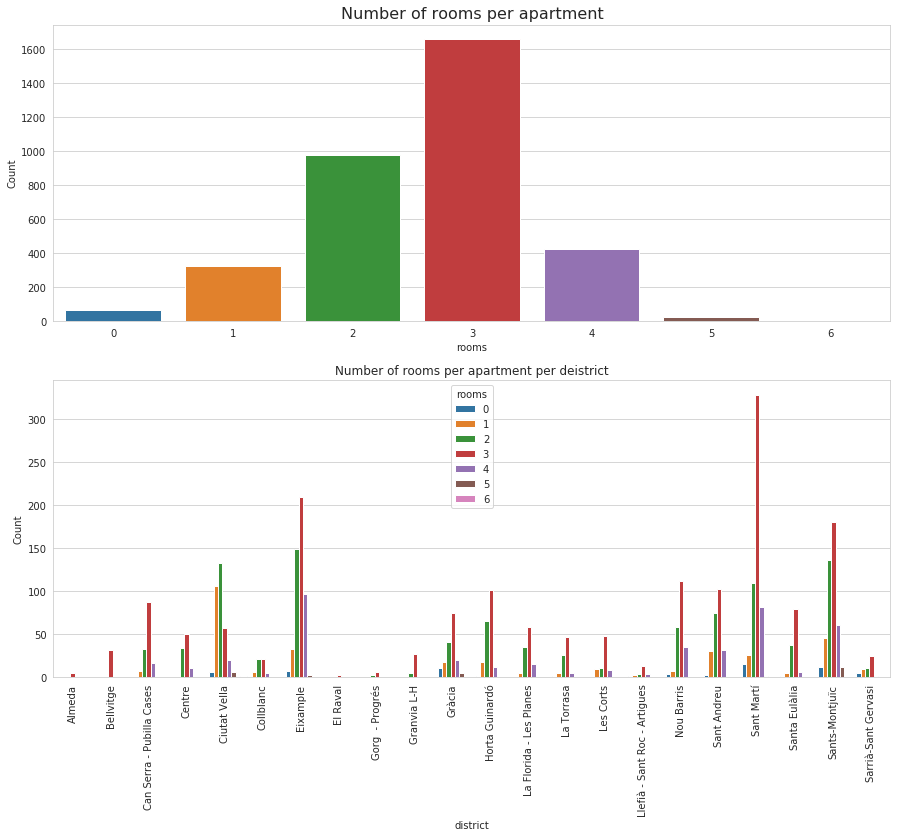

In [15]:
sns.set_style("whitegrid")
fig_size = (15,12)
fig, ax = plt.subplots(2, figsize=fig_size)

sns.countplot(x='rooms', orient = 0, data = df, ax = ax[0])
ax[0].set_title('Number of rooms per apartment', fontsize=16);
ax[0].set_ylabel('Count');

sns.countplot(x = 'district', hue = 'rooms', orient = 0, data = df, ax = ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90);
ax[1].set_title('Number of rooms per apartment per deistrict');
ax[1].set_ylabel('Count');


## Analyze the relationship of floor and price

### Clean floors
Clean floors and create new numerical column 'floorSort' with floor values

In [16]:
df['floor'] = df['floor'].astype('string')
df['floorSort'] = df['floor']
df['floorSort'].replace('en', str(0), inplace= True) # entreplanta = 0
df['floorSort'].replace('bj', str(-1), inplace= True) # bajo = -1
df['floorSort'].replace('ss', str(-1), inplace= True) # semisotano = -1
df['floorSort'].replace('st', str(-1), inplace= True) # semisotano = -1
df['floorSort'].replace('nan', str(-2), inplace= True) # nan = -2
df['floorSort'].replace('Unknown', str(-1), inplace= True) # Set unknown to -2

df.floorSort = df.floorSort.apply(pd.to_numeric)

# 'st' and 'ss' are bothsemisotano
df['floor'].replace('st', 'ss', inplace= True) 

# Show property type 'Penthouse' as floor
df.loc[df['propertyType'] == 'penthouse', 'floor'] =  'Penthouse'# Set unknown to -2
df.loc[df['propertyType'] == 'penthouse', 'floorSort'] =  df.floorSort.max() + 1# Set unknown to -2

# Create new categorical variable with floors
df['floorCategorical'] = df['floor']
df.loc[df['floorSort']==-2, ['floorCategorical']] = None
df.loc[(df['floorSort']>=1)&(df['floorSort']<=3), ['floorCategorical']] = 'Low'
df.loc[(df['floorSort']>=4)&(df['floorSort']<=6), ['floorCategorical']] = 'Mid'
df.loc[(df['floorSort']>=7)&(df['floor']!='Penthouse'), ['floorCategorical']] = 'High'
df['floorCategorical'] = df['floorCategorical'].astype('category')


### Counts and price distribution per floor

Text(0, 0.5, 'Price by Area')

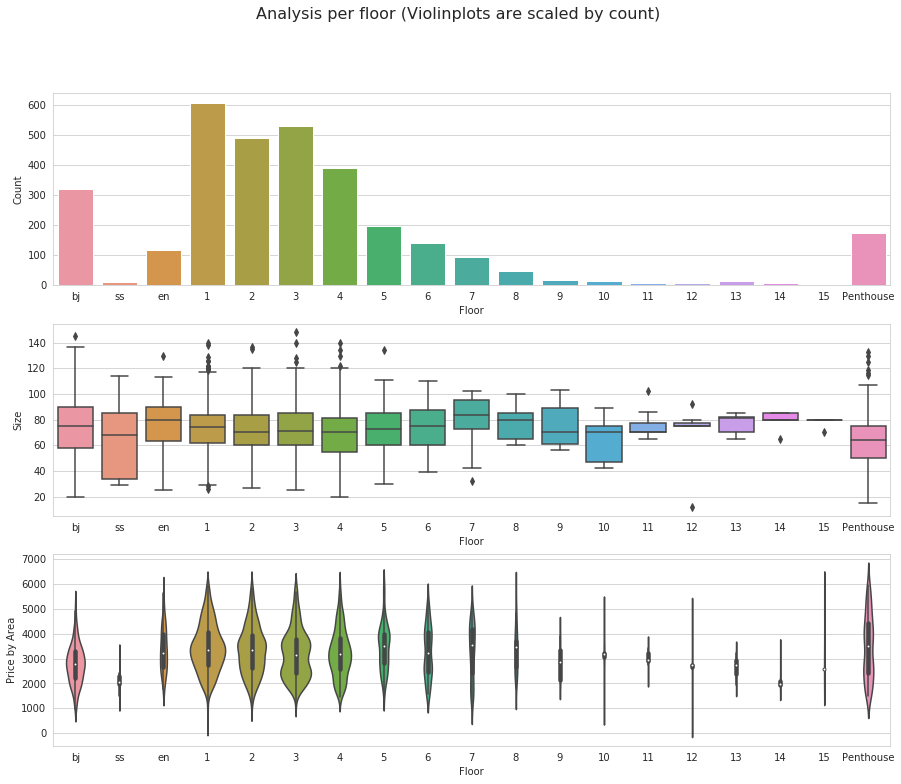

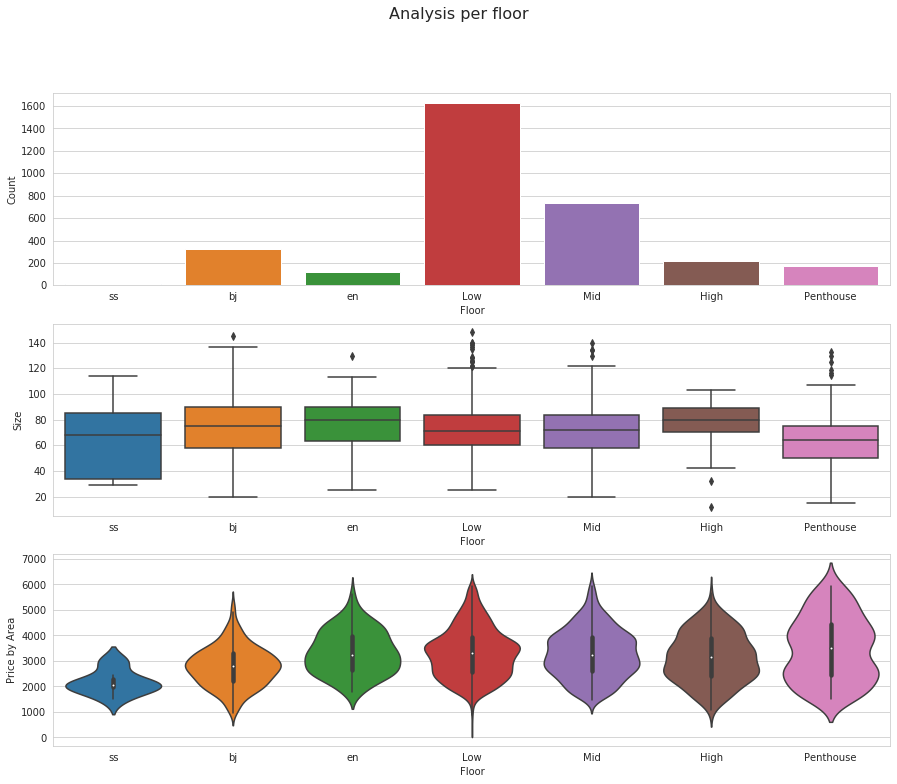

In [17]:
# Do not plot NaNs
fig_size = (15, 12)
fig, ax = plt.subplots(3, figsize=fig_size)
fig.suptitle(
    'Analysis per floor (Violinplots are scaled by count)', fontsize=16)
sns.countplot(x='floor', data=df.loc[df['floorSort'] != -
                                     2].sort_values(by=['floorSort']), orient='v', ax=ax[0])
ax[0].set_xlabel('Floor')
ax[0].set_ylabel('Count')

sns.boxplot(x='floor', y='size',
            data=df.loc[df['floorSort'] != -2].sort_values(by=['floorSort']), ax=ax[1])
ax[1].set_xlabel('Floor')
ax[1].set_ylabel('Size')

sns.violinplot(x='floor', y='priceByArea', scale='count',
               data=df.loc[df['floorSort'] != -2].sort_values(by=['floorSort']), ax=ax[2])
ax[2].set_xlabel('Floor')
ax[2].set_ylabel('Price by Area')


# Plot 'floorCategorical'
fig_size = (15, 12)
fig, ax = plt.subplots(3, figsize=fig_size)
fig.suptitle(
    'Analysis per floor', fontsize=16)
sns.countplot(x='floorCategorical', data=df, order=[
              'ss', 'bj', 'en', 'Low', 'Mid', 'High', 'Penthouse'], orient='v', ax=ax[0])
ax[0].set_xlabel('Floor')
ax[0].set_ylabel('Count')

sns.boxplot(x='floorCategorical', y='size', data=df, order=[
              'ss', 'bj', 'en', 'Low', 'Mid', 'High', 'Penthouse'], ax=ax[1])
ax[1].set_xlabel('Floor')
ax[1].set_ylabel('Size')

sns.violinplot(x='floorCategorical', y='priceByArea', scale='width', data=df,
               order=['ss', 'bj', 'en', 'Low', 'Mid', 'High', 'Penthouse'], ax=ax[2])
ax[2].set_xlabel('Floor')
ax[2].set_ylabel('Price by Area')

### Analyze number of penthouses per district

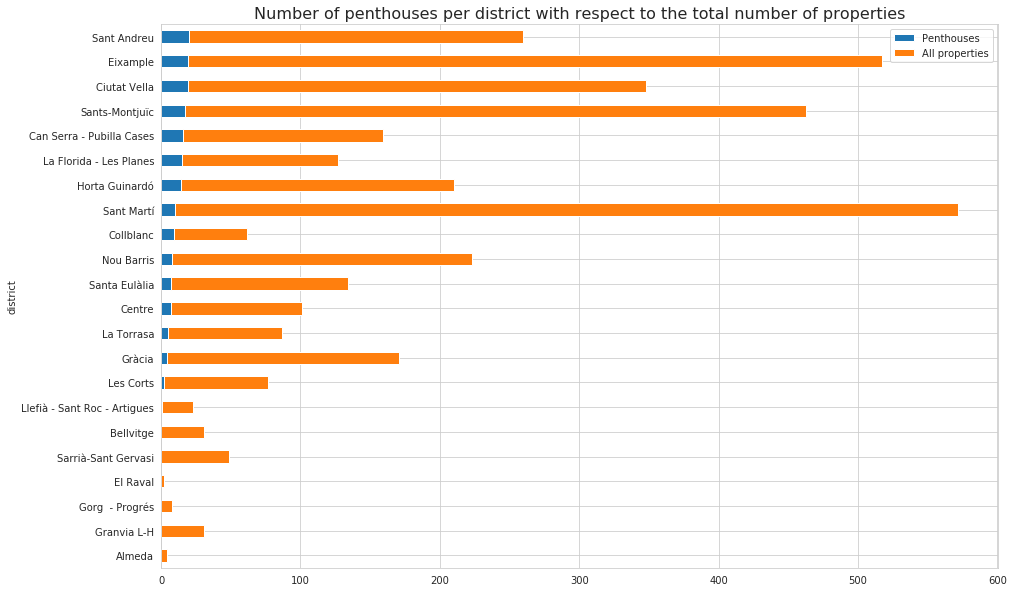

In [18]:
def get_penthouse(x):
    return x.loc[x == 'penthouse'].count()


def get_all_properties(x):
    return x.count()


fig, ax = plt.subplots(1, figsize=(15, 10))


aux = df[['district', 'propertyType']].groupby(['district']).agg(
    [get_penthouse, get_all_properties])
aux.columns = ['Penthouses', 'All properties']
aux.sort_values(by='Penthouses').plot.barh(stacked=True, ax=ax)
ax.set_title(
    'Number of penthouses per district with respect to the total number of properties', 
    fontsize=16);

## Location

### Plot properties to the map
Plot properties and penthouses with respect to price by area and size.

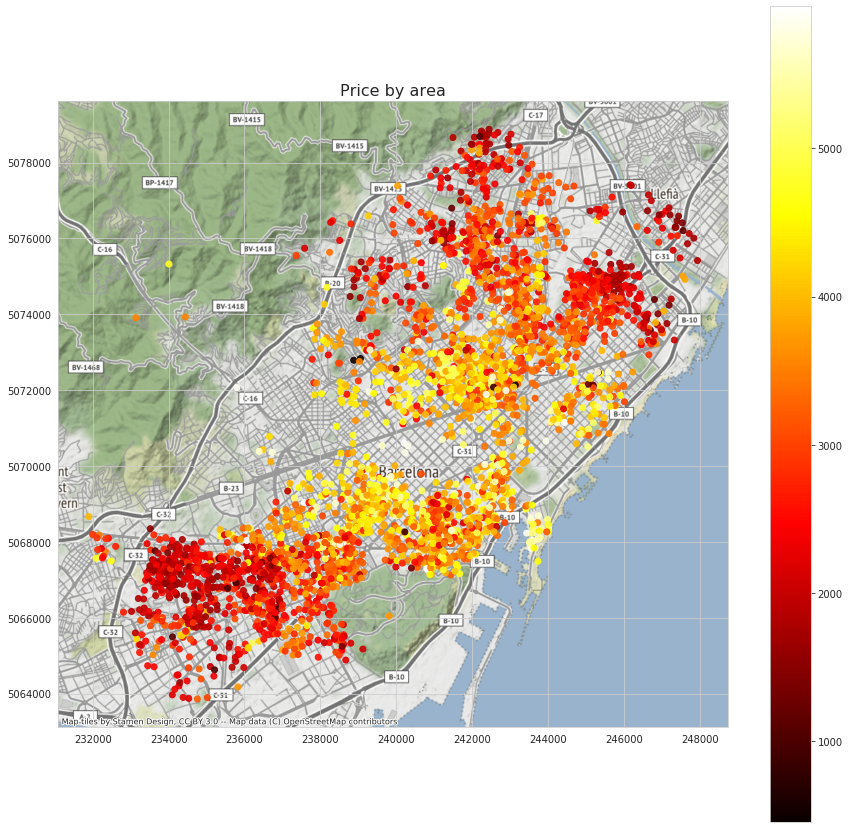

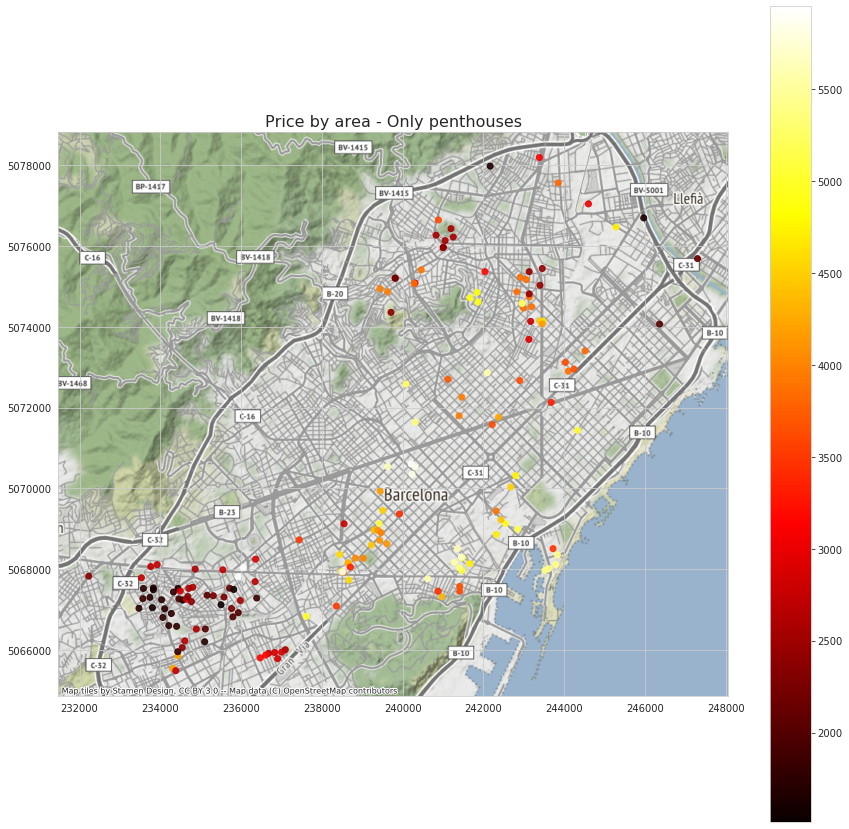

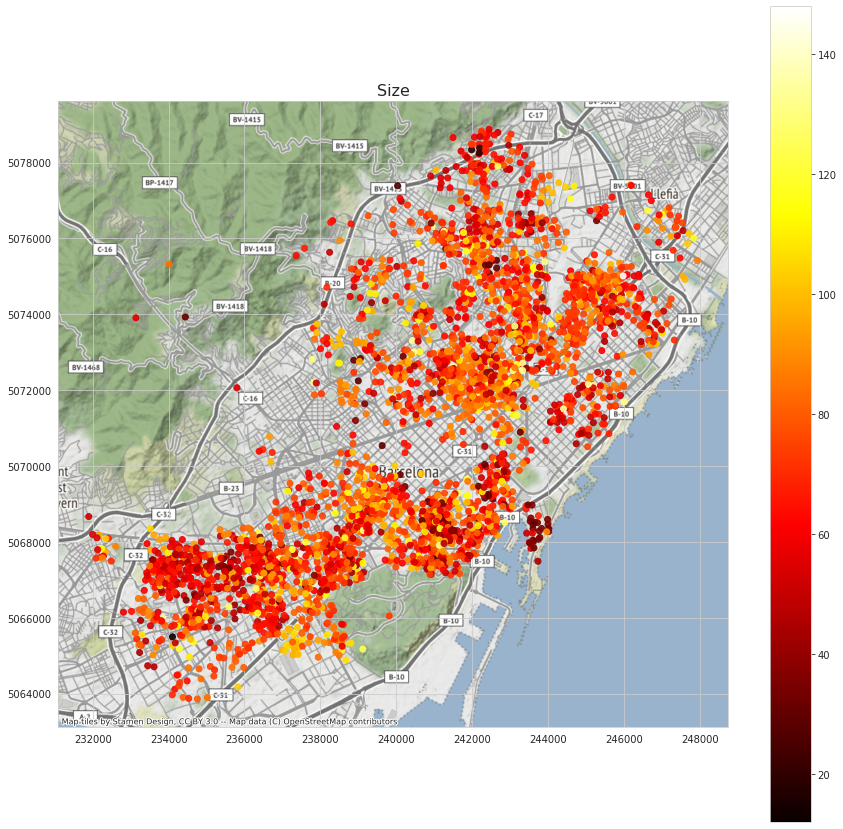

In [19]:
import geopandas as gpd
import descartes
import contextily as ctx


gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.crs = {'init': 'epsg:4326'}
gdf = gdf.to_crs(epsg=3857)

figsize = (15,15)
fig, ax = plt.subplots(1, figsize=figsize)
gdf.plot(column='priceByArea', cmap='hot',  legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Price by area", fontsize=16);

fig, ax = plt.subplots(1, figsize=figsize)
gdf.loc[gdf['propertyType'] == 'penthouse'].plot(
    column='priceByArea', cmap='hot', legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Price by area - Only penthouses", fontsize=16);

fig, ax = plt.subplots(1, figsize=figsize)
gdf.plot(column='size', cmap='hot', legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Size", fontsize=16);

### Analyze prices per district

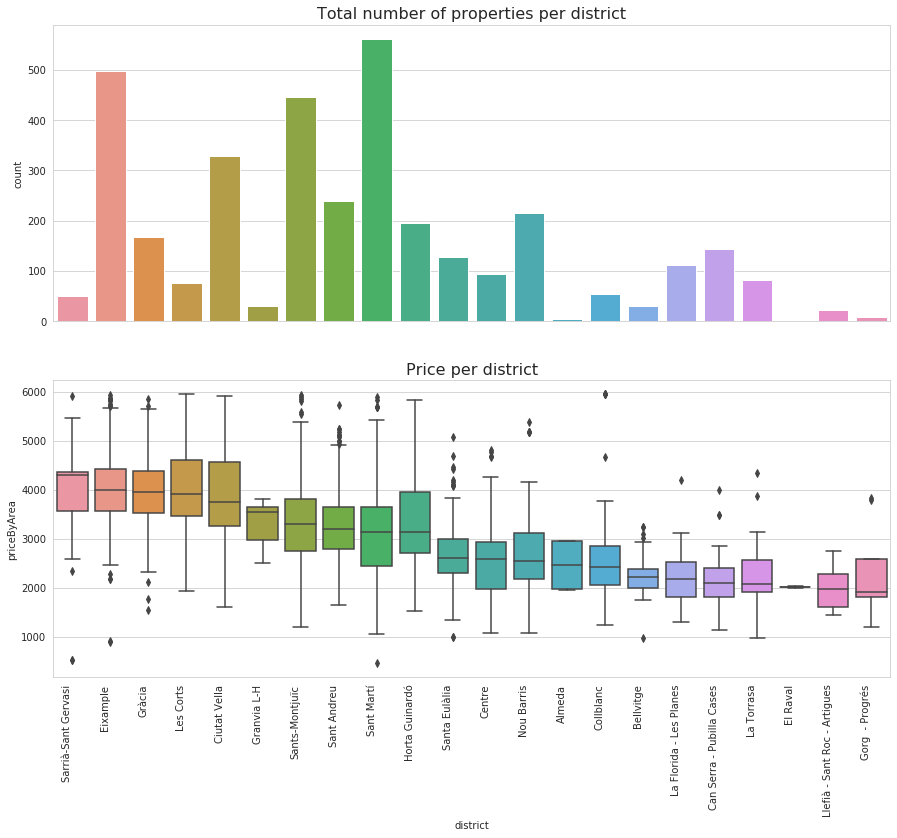

In [20]:
fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)

sns.countplot(x='district', data=df,
              order=df.groupby('district')['priceByArea'].median().sort_values(ascending=False).index, orient='v', ax=ax[0])
ax[0].set_xticks([])
ax[0].set_xlabel(None)
ax[0].set_title(
    'Total number of properties per district', fontsize=16);

sns.boxplot(y='priceByArea', x='district', data=df, ax=ax[1],
            order=df.groupby('district')['priceByArea'].median().sort_values(ascending=False).index)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right')
ax[1].set_title(
    'Price per district', fontsize=16);

### Change in price over time
Check the fluctuations per week

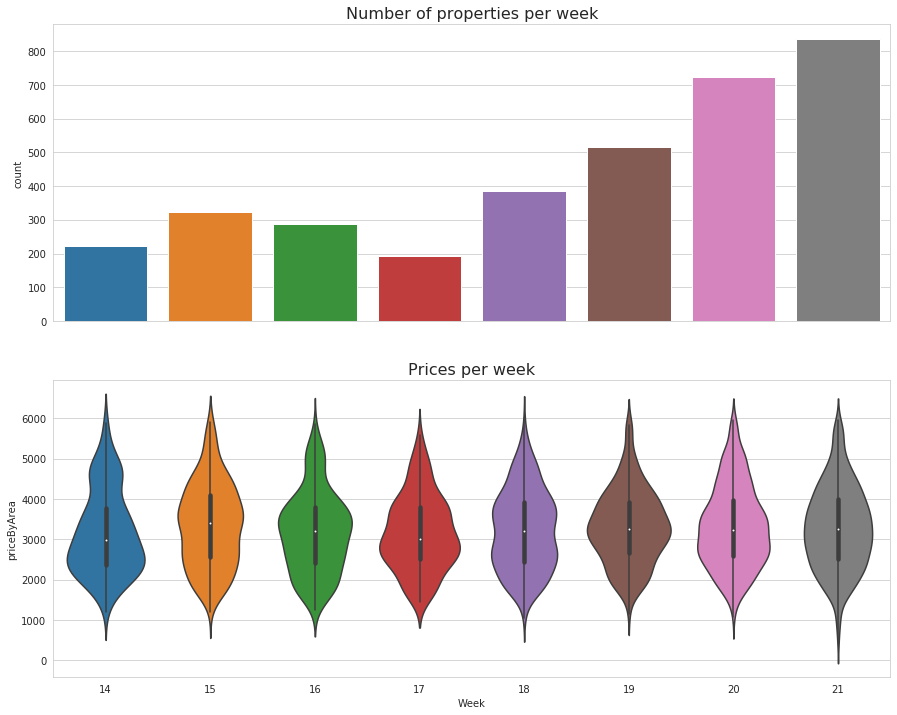

In [21]:
fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)

sns.countplot(x='Week', data=df, ax=ax[0])
ax[0].set_xticks([])
ax[0].set_xlabel(None)
ax[0].set_title(
    'Number of properties per week', fontsize=16);

sns.violinplot(x='Week', y='priceByArea', data=df, ax=ax[1])
ax[1].set_title(
    'Prices per week', fontsize=16);

# Analysis of apartment status

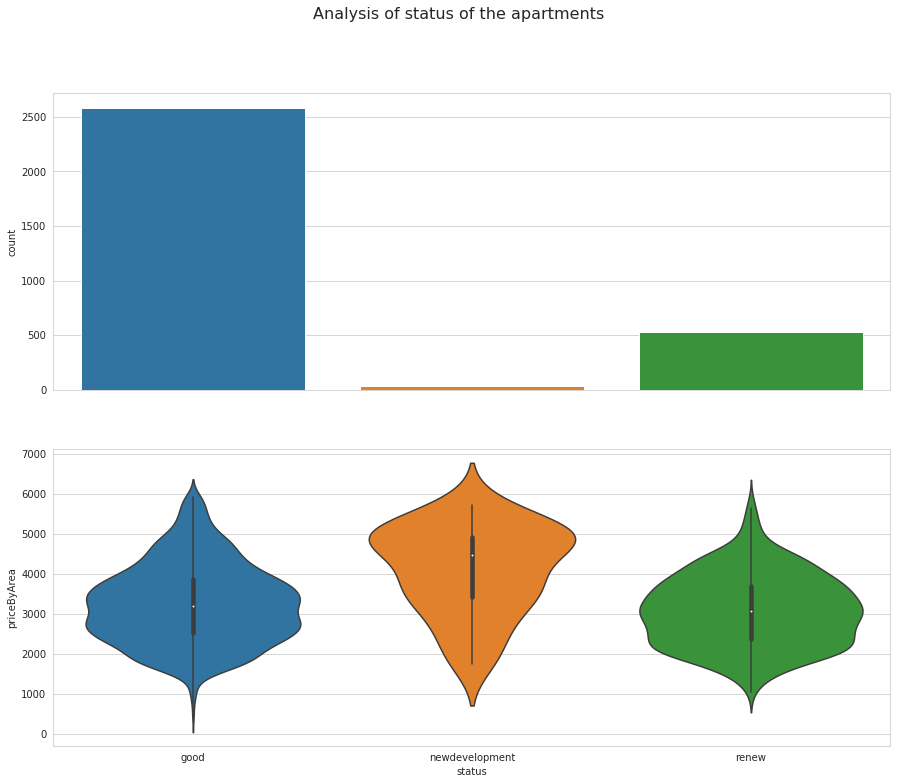

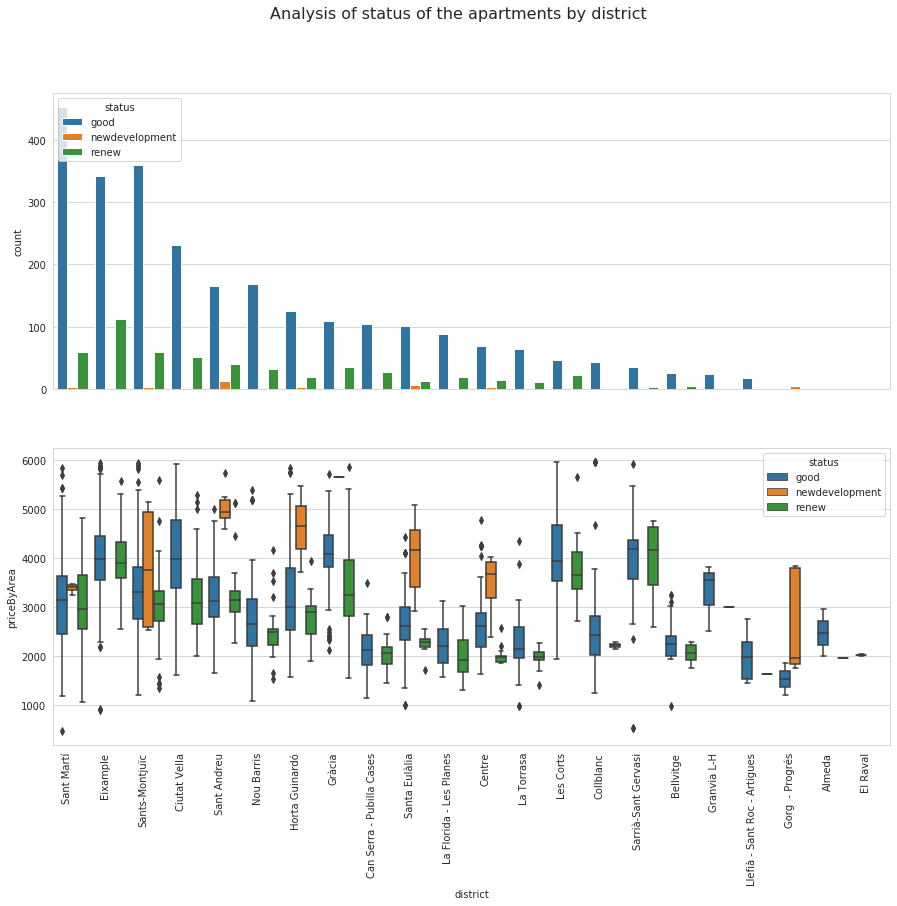

In [22]:
fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)
sns.countplot(x='status', data=df, ax=ax[0]);
ax[0].set_xticks([]);
ax[0].set_xlabel(None);
sns.violinplot(y='priceByArea', x= 'status', data=df, ax=ax[1])
fig.suptitle('Analysis of status of the apartments', fontsize=16);

fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)
sns.countplot(x='district', hue='status', data=df, ax=ax[0],
             order=df.groupby('district')['status'].count().sort_values(ascending=False).index);
ax[0].set_xticks([]);
ax[0].set_xlabel(None);
sns.boxplot(x='district', y='priceByArea', hue='status',data=df,ax=ax[1],
           order=df.groupby('district')['status'].count().sort_values(ascending=False).index);
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right');
fig.suptitle('Analysis of status of the apartments by district', fontsize=16);

## Analysis of elevator
Check if the elevator has an effect on the price

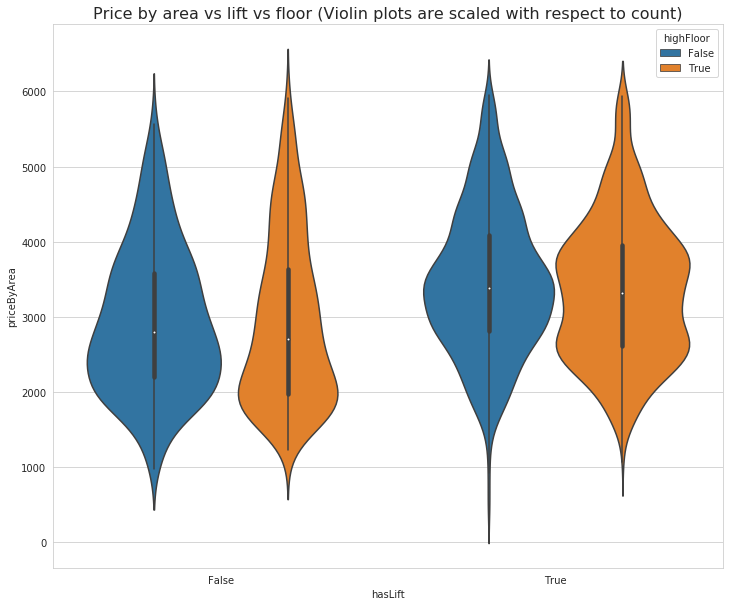

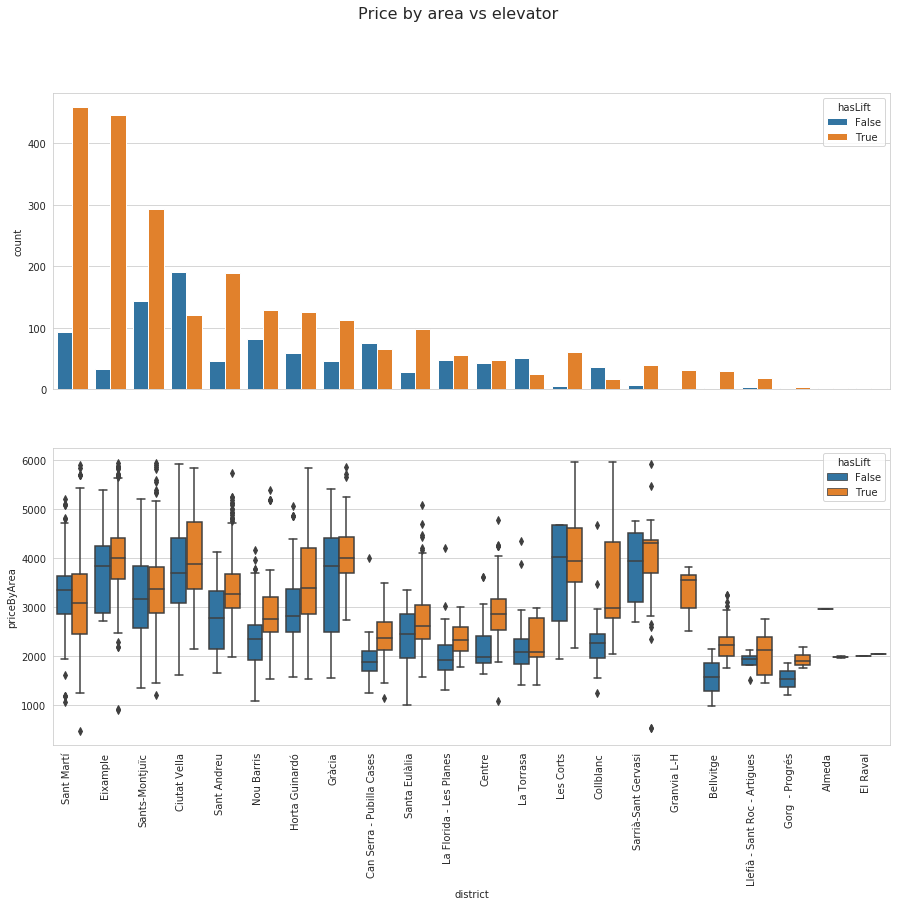

In [23]:
# Compare price by area depending on the floor and the lift
fig_size = (12, 10)
fig, ax = plt.subplots(1, figsize=fig_size)
aux=df
aux['highFloor']=False
aux.loc[aux['floorSort']>2, 'highFloor'] = True
sns.violinplot(x='hasLift', y='priceByArea', hue='highFloor', scale='count', data=aux,ax=ax);
ax.set_title('Price by area vs lift vs floor (Violin plots are scaled with respect to count)', fontsize=16);

fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)
sns.countplot(x='district', hue='hasLift', data=df, ax=ax[0],
             order=df.groupby('district')['hasLift'].count().sort_values(ascending=False).index);
ax[0].set_xticks([]);
ax[0].set_xlabel(None);

sns.boxplot(x='district', y='priceByArea', hue='hasLift', data=df,ax=ax[1],
           order=df.groupby('district')['hasLift'].count().sort_values(ascending=False).index);
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right');
fig.suptitle('Price by area vs elevator', fontsize=16);

## Exterior/interior
Check  the effect of interior/exterior property on the price

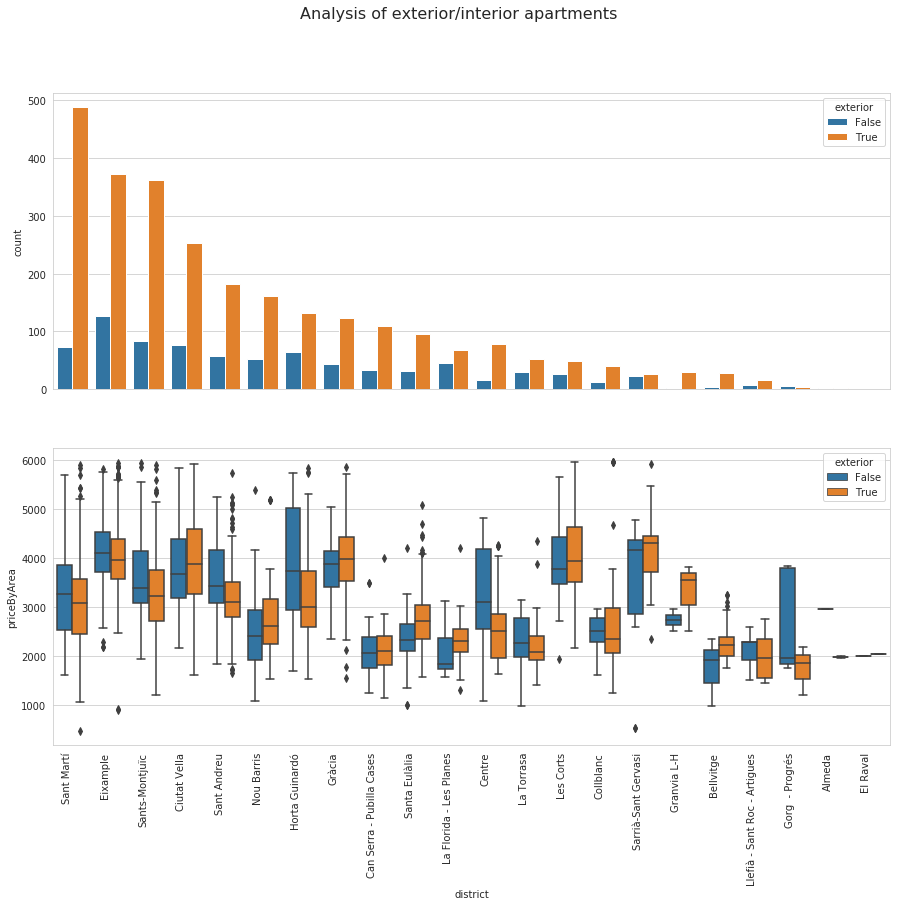

In [24]:
fig_size = (15, 12)
fig, ax = plt.subplots(2, figsize=fig_size)
sns.countplot(x='district', hue='exterior', data=df, ax=ax[0],
             order=df.groupby('district')['exterior'].count().sort_values(ascending=False).index);
ax[0].set_xticks([]);
ax[0].set_xlabel(None);

sns.boxplot(x='district', y='priceByArea', hue='exterior',data=df,ax=ax[1],
           order=df.groupby('district')['exterior'].count().sort_values(ascending=False).index);
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90,
                      horizontalalignment='right');
fig.suptitle('Analysis of exterior/interior apartments', fontsize=16);

# Price Prediction
Using regression a price for each property is predicted. The properties with a significantly lower price than the predicted value are identified as a good investment oportunity.

### Organize and clean the data

In [25]:
# Print the names of the columns
print('Available features are:')
for i in df.columns:
    print(i, end=', ')

df_model = df[['propertyType', 'size', 'exterior', 'rooms', 'bathrooms',
              'latitude', 'longitude', 'priceByArea', 'status', 'hasLift', 'Week', 'floorCategorical']]

Available features are:
propertyCode, floor, price, propertyType, size, exterior, rooms, bathrooms, district, neighborhood, latitude, longitude, priceByArea, status, hasLift, Week, duplicatesIndex, duplicates, duplicatesCount, dupPriceMin, dupPriceMax, dupPriceByAreaMin, dupPriceByAreaMax, dupWeekMin, dupWeekMax, dupPriceDifference, dupPriceDifference%, floorSort, floorCategorical, geometry, highFloor, 

In [26]:
def clean_modelling_data(df):
    data = df
    
    # drop NaNs
    numberOfNans = data.isnull().sum().sum()/data.shape[0]
    #assert numberOfNans<0.05, "Oh no! The number of NaNs is "+str(numberOfNans)+"%"
    print("The number of NaNs is "+str(numberOfNans)+"%")
    data = data.dropna().reset_index(drop=True)
    data['hasLift'] = data['hasLift'].astype('bool')

    # get 0/1 for bool varibales
    data['exterior'] = data['exterior'].astype(int)
    data['hasLift'] = data['hasLift'].astype(int)

    # get dummies for categorical variables
    data = pd.get_dummies(data)
    return data

df_model = clean_modelling_data(df_model)

The number of NaNs is 0.21141709695926564%


### Linear Regression
Simple linear regression model and the performance

The mean squared error (MSE) on train set: 695193.8516
The mean squared error (MSE) on test set: 641947.2664

The R square (R2) on train set: 0.2657
The R square (R2) on test set: 0.3244


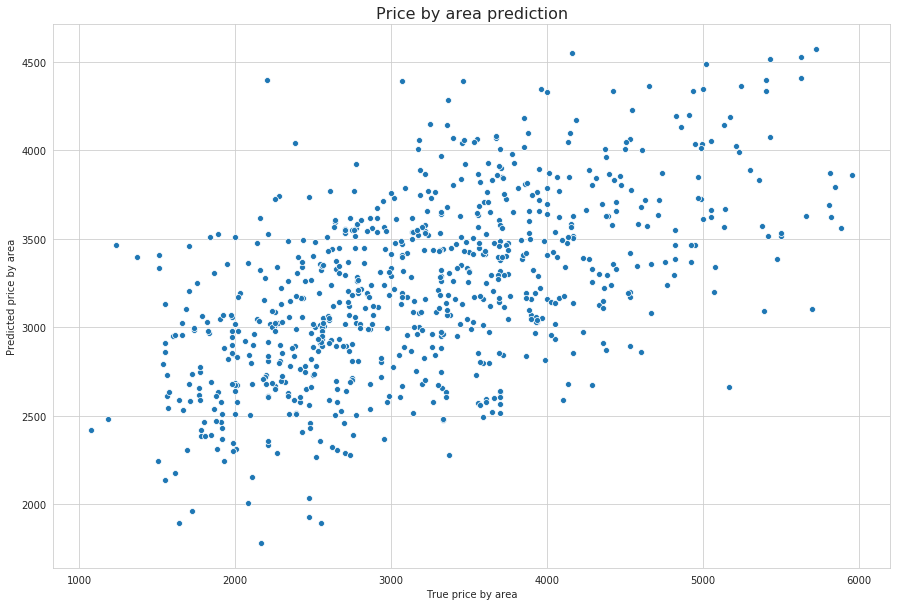

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

reg = LinearRegression()

labels = df_model['priceByArea']
train1 = df_model.drop(['priceByArea'],axis=1)
x_train , x_test , y_train , y_test = train_test_split(train1 , labels , test_size = 0.25,random_state =2)

reg.fit(x_train,y_train)
reg.score(x_test,y_test)

mse_train = mean_squared_error(y_train, reg.predict(x_train))
mse_test = mean_squared_error(y_test, reg.predict(x_test))
R2_train = reg.score(x_train,y_train)
R2_test = reg.score(x_test,y_test)
print("The mean squared error (MSE) on train set: {:.4f}".format(mse_train))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse_test))
print("\nThe R square (R2) on train set: {:.4f}".format(R2_train))
print("The R square (R2) on test set: {:.4f}".format(R2_test))
fig,ax= plt.subplots(1,figsize=(15, 10))
sns.scatterplot(x=y_test, y=reg.predict(x_test));
ax.set_ylabel('Predicted price by area');
ax.set_xlabel('True price by area');
ax.set_title('Price by area prediction', fontsize=16);

#plt.scatter(y_test, reg.predict(x_test),  color='black');

#### Improve the linear regression using ensemble learner
Improve the linear regression using Gradient Boosting Regressor

The mean squared error (MSE) on train set: 234.6540
The mean squared error (MSE) on test set: 328104.0315

The R square (R2) on train set: 0.9998
The R square (R2) on test set: 0.6547


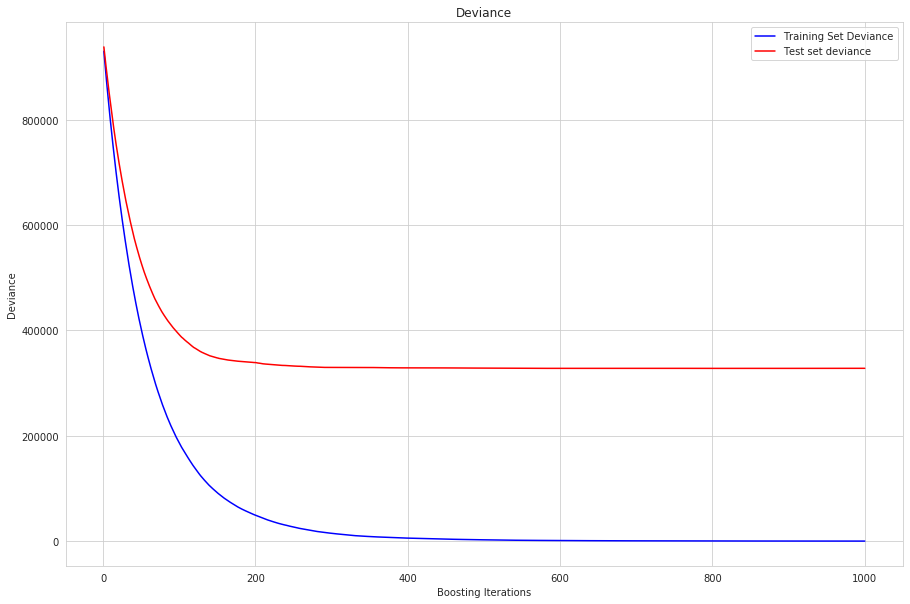

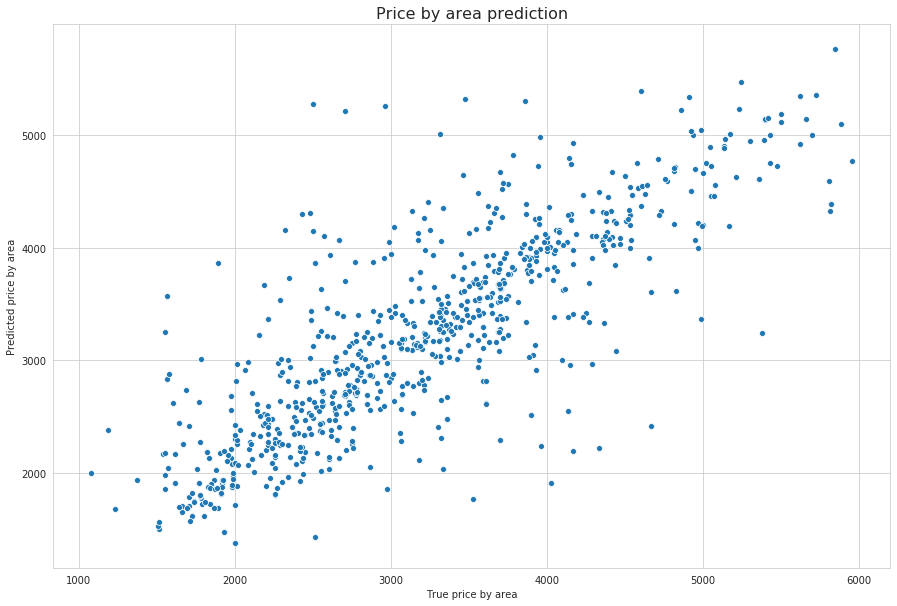

In [28]:
params = {'n_estimators': 1000,
          'max_depth': 12,
          'min_samples_split': 2,
          'learning_rate': 0.01,
          'loss': 'ls'}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_train, y_train)

mse_train = mean_squared_error(y_train, reg.predict(x_train))
mse_test = mean_squared_error(y_test, reg.predict(x_test))
R2_train = reg.score(x_train,y_train)
R2_test = reg.score(x_test,y_test)
print("The mean squared error (MSE) on train set: {:.4f}".format(mse_train))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse_test))
print("\nThe R square (R2) on train set: {:.4f}".format(R2_train))
print("The R square (R2) on test set: {:.4f}".format(R2_test))

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(x_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig,ax= plt.subplots(1,figsize=(15, 10))

plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
        label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-', label='Test set deviance')
        
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.title('Deviance')

fig,ax= plt.subplots(1,figsize=(15, 10))
sns.scatterplot(x=y_test, y=reg.predict(x_test));
ax.set_ylabel('Predicted price by area');
ax.set_xlabel('True price by area');
ax.set_title('Price by area prediction', fontsize=16);


The R square (R2) on test set: 0.8210


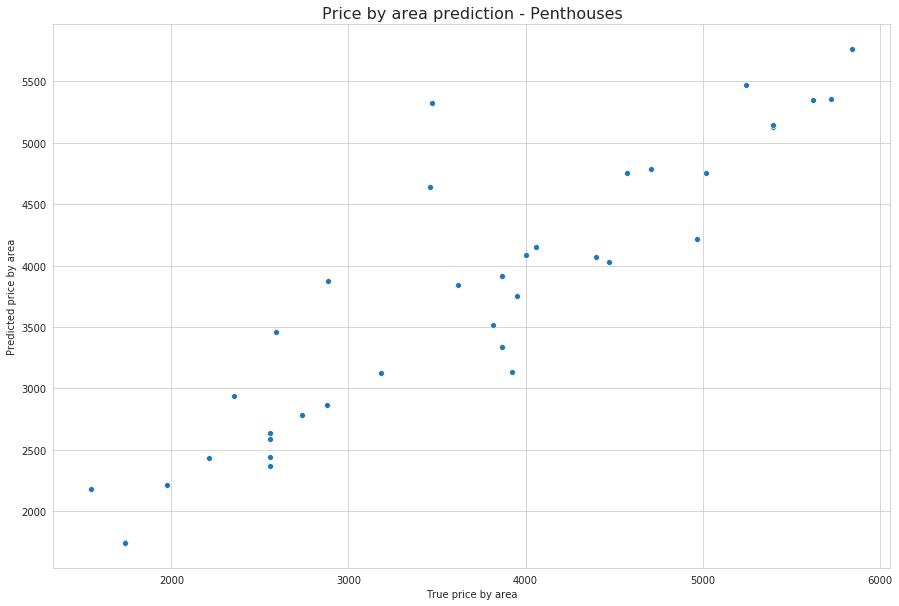

In [29]:
# Analyse error on Penthouses
R2_test_penthouse = reg.score(
    x_test.loc[x_test['propertyType_penthouse'] == 1], y_test.loc[x_test['propertyType_penthouse'] == 1])
print("The R square (R2) on test set: {:.4f}".format(R2_test_penthouse))

fig, ax = plt.subplots(1, figsize=(15, 10))
sns.scatterplot(x=y_test.loc[x_test['propertyType_penthouse'] == 1], y=reg.predict(
    x_test.loc[x_test['propertyType_penthouse'] == 1]))
ax.set_ylabel('Predicted price by area');
ax.set_xlabel('True price by area');
ax.set_title('Price by area prediction - Penthouses', fontsize=16);

#### Perform Permutation Feature Importance analysis

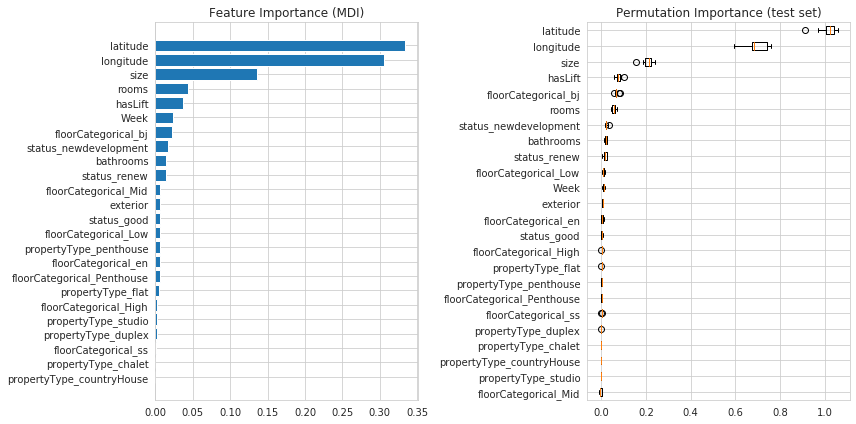

In [30]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(train1.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, x_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(train1.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()

### Identify the best offers in terms of Price by Area

#### Train the model on all samples

The number of NaNs is 0.21141709695926564%
Using features:
size, rooms, bathrooms, latitude, longitude, priceByArea, hasLift, Week, propertyType_flat, propertyType_penthouse, status_renew, floorCategorical_Low, floorCategorical_bj, The mean squared error (MSE) on train set: 9006.4723
The R square (R2) on train set: 0.9905


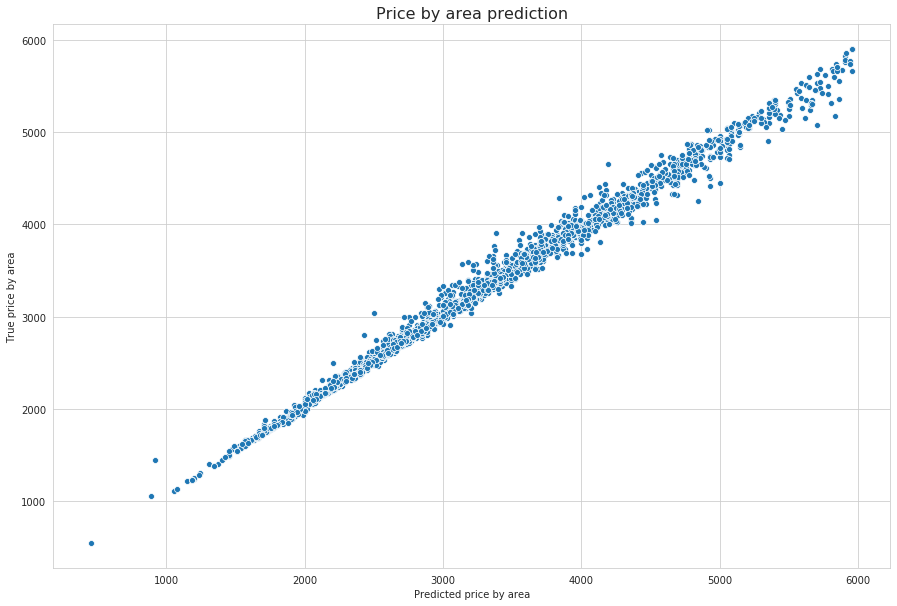

In [31]:
# Recreate feature set
df_model = df[['propertyType', 'size', 'exterior', 'rooms', 'bathrooms',
              'latitude', 'longitude', 'priceByArea', 'status', 'hasLift', 'Week', 'floorCategorical']]
df_model = clean_modelling_data(df_model)

# Drop unnecessary features
df_model = df_model.drop(['propertyType_studio', 'propertyType_duplex', 'propertyType_countryHouse', 'propertyType_chalet',
                          'status_newdevelopment', 'status_good', 'exterior',
                         'floorCategorical_High', 'floorCategorical_Mid', 'floorCategorical_en', 'floorCategorical_ss',
                          'floorCategorical_Penthouse'
                         ], axis=1)

# Print the names of the columns
print('Using features:')
for i in df_model.columns:
    print(i, end=', ')

params = {'n_estimators': 400,
          'max_depth': 12,
          'min_samples_split': 2,
          'learning_rate': 0.01,
          'loss': 'ls'}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(df_model.drop(['priceByArea'], axis=1), df_model['priceByArea'])

mse_train = mean_squared_error(df_model['priceByArea'], reg.predict(
    df_model.drop(['priceByArea'], axis=1)))
R2_train = reg.score(df_model.drop(
    ['priceByArea'], axis=1), df_model['priceByArea'])
print("The mean squared error (MSE) on train set: {:.4f}".format(mse_train))
print("The R square (R2) on train set: {:.4f}".format(R2_train))

fig, ax = plt.subplots(1, figsize=(15, 10))
sns.scatterplot(df_model['priceByArea'], reg.predict(
    df_model.drop(['priceByArea'], axis=1)))
ax.set_ylabel('True price by area');
ax.set_xlabel('Predicted price by area');
ax.set_title('Price by area prediction', fontsize=16);

#### Create new columns in df with predicted price, price difference, and savings

In [32]:
df_model['predictedPrice'] = reg.predict(df_model.drop(['priceByArea'],axis=1))
# Price difference = PredictedPrice- priceByArea ==> the higher numbers are better investment
df_model['priceDifference'] = df_model['predictedPrice']-df_model['priceByArea']

df=df.join(df_model[['predictedPrice', 'priceDifference']])
df['savings'] = df['size']*df['priceDifference']

Show only the properties cheaper more than 'threshold' than predicted price (e.g. 10 000 euros).

In [33]:
# show only the properties cheaper by threashold from predicted price 
saving_threashold = 10000
df_investment=df.loc[df['savings'] > saving_threashold]

df_investment.sort_values(by='savings',ascending=False).head(50)

propertyCode      floor     price propertyType   size  exterior  rooms  \
2844     89411856          1  379000.0         flat   87.0      True      3   
604      89209223          7  350000.0         flat   84.0     False      3   
1730     89286662          7  339000.0         flat   95.0      True      4   
2304     89383122          3  159000.0         flat   80.0      True      4   
2415     89371971          1  140000.0         flat   64.0      True      3   
1969     88653219          2  305000.0         flat   80.0      True      4   
1982     88082345          2  354000.0         flat  107.0      True      4   
2824     89422064          4  359000.0         flat   87.0      True      4   
2927     89446262         bj  210000.0         flat   75.0      True      2   
1162     89268477          4  220000.0         flat   80.0      True      4   
541      89107041        nan   84400.0         flat   55.0      True      1   
1293     82123859         bj  227000.0         flat  113.0     False      4   
469      89141776          8  255000.0         flat   73.0      True      3   
1322     89240189          4  199000.0         flat   90.0      True      3   
152      89102570        nan  320000.0         flat   85.0     False      4   
2882     89368885         en  344400.0         flat   69.0      True      1   
2416     89349748          7  274000.0         flat   84.0      True      4   
1580     89308137          2  258000.0         flat   70.0      True      2   
1648     89045707          1  320000.0         flat   98.0      True      4   
1304     89250467          3  350000.0         flat   95.0     False      3   
865      89222965          5  360000.0         flat   95.0      True      3   
1869     89282603          2  210000.0         flat   69.0      True      3   
2125     89353296          5  298000.0         flat   90.0      True      3   
1703     89299748  Penthouse  200000.0    penthouse   82.0      True      4   
1302     89248876          3  345000.0         flat   64.0      True      2   
2952     89492622          3  375000.0         flat   92.0      True      3   
2686     88074510          2  285000.0         flat   80.0      True      3   
1056     88897845          4  345000.0         flat   73.0     False      2   
2294     88893937          2  338000.0         flat   71.0      True      1   
1029     89241240         bj  210000.0         flat   90.0      True      3   
1932     89356866          3  305000.0         flat   90.0     False      3   
1050     89262849          3  390000.0         flat  100.0      True      4   
1740     89284804          2  210000.0         flat   69.0      True      3   
1614     89298467          3  350000.0         flat   89.0     False      3   
1187     89262879         bj  209000.0         flat  103.0      True      2   
2343     89346363          1  298000.0         flat   77.0      True      2   
2206     89364987          1  227000.0         flat   75.0     False      4   
807      89199588          1  285000.0         flat   93.0      True      3   
2802     89420561          1  235000.0         flat   73.0      True      3   
975      89230111          6  360000.0         flat   82.0      True      3   
1502     89274267          2  330000.0         flat   96.0      True      4   
1335     85534598          2  262000.0         flat  116.0      True      3   
664      89211684          6  360000.0         flat   82.0      True      3   
2054     85202374          1  399500.0         flat  101.0      True      4   
952      89216751          1  310000.0         flat  110.0      True      3   
1240     84556304          2  135000.0         flat   62.0      True      3   
1098     89255946          3  290000.0         flat  115.0      True      4   
523      89129429          4  220000.0         flat   79.0      True      4   
2498     89329913          3  350000.0         flat   95.0      True      3   
1587     85369690         bj   98000.0         flat   4

#### Plot the identified properties on the map

Text(0.5, 1, 'Savings - Penthouses')

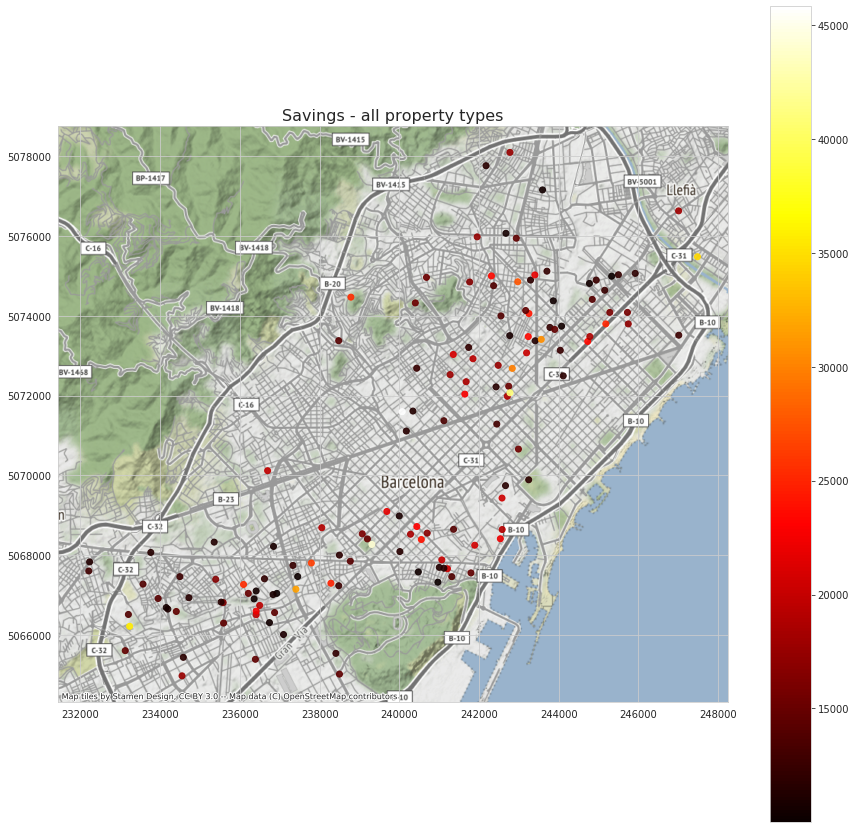

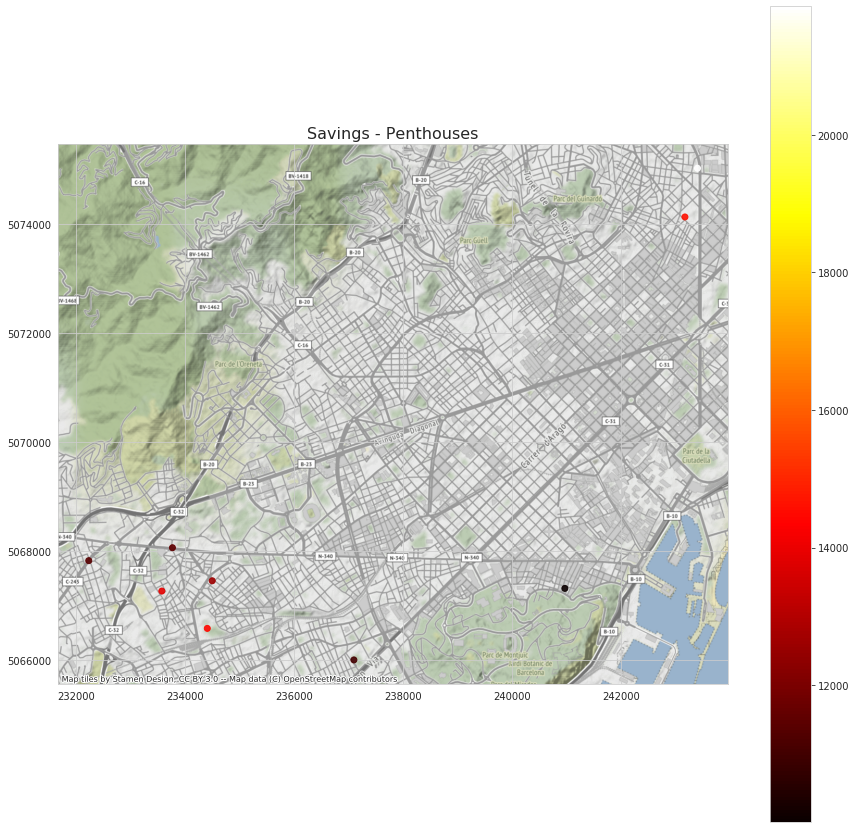

In [67]:
gdf = gpd.GeoDataFrame(
    df_investment, geometry=gpd.points_from_xy(df_investment.longitude, df_investment.latitude))
gdf.crs = {'init': 'epsg:4326'}
gdf = gdf.to_crs(epsg=3857)

figsize = (15, 15)
fig, ax = plt.subplots(1, figsize=figsize)
gdf.plot(column='savings', cmap='hot', legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Savings - all property types", fontsize=16)

figsize = (15, 15)
fig, ax = plt.subplots(1, figsize=figsize)
gdf.loc[gdf['propertyType'] == 'penthouse'].plot(
    column='savings', cmap='hot', legend=True, alpha=0.9, ax=ax)
ctx.add_basemap(ax)
ax.set_title("Savings - Penthouses", fontsize=16)

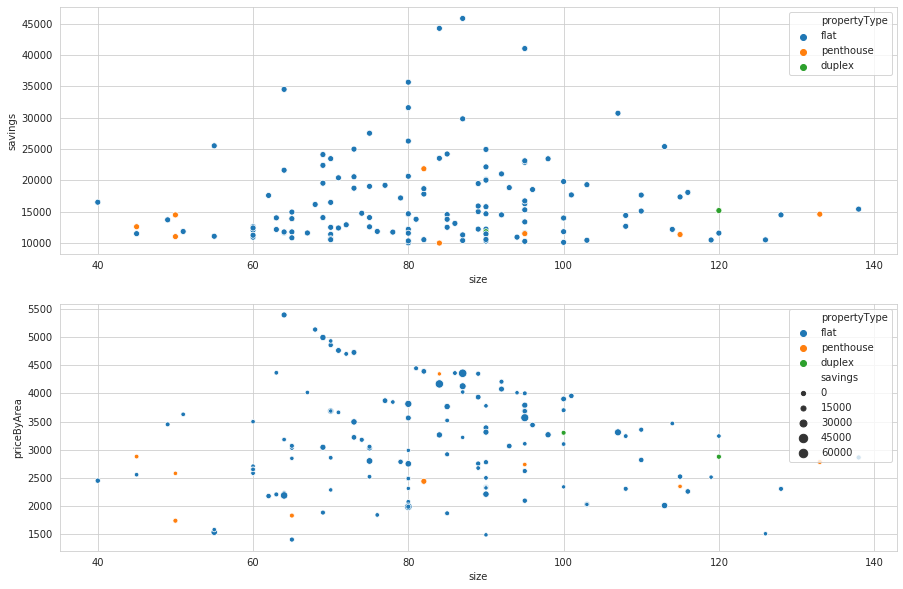

In [35]:
fig,ax= plt.subplots(2,figsize=(15, 10))
sns.scatterplot(x='size', y='savings', hue= 'propertyType', data=df_investment,ax=ax[0]);
#sns.scatterplot(x='size', y='priceByArea', hue= 'savings', data=df,ax=ax[1]);
sns.scatterplot(x='size', y='priceByArea', size= 'savings', hue='propertyType', data=df_investment,ax=ax[1]);

#### Get the identifier of the selected property

In [36]:
# E.g.:
df_investment.loc[(df_investment['size'] > 70) & (df_investment['size'] < 100) & (
    df_investment['propertyType'] == 'penthouse')].sort_values(by='savings', ascending=False)

propertyCode      floor     price propertyType  size  exterior  rooms  \
1703     89299748  Penthouse  200000.0    penthouse  82.0      True      4   
2285     89333259  Penthouse  260000.0    penthouse  95.0      True      3   
643      88528169  Penthouse  365000.0    penthouse  84.0      True      2   

      bathrooms                   district                     neighborhood  \
1703          1                Sant Andreu                       La Sagrera   
2285          1  Can Serra - Pubilla Cases                    Pubilla Cases   
643           1             Sants-Montjuïc  El Poble Sec - Parc de Montjuïc   

       latitude  longitude  priceByArea status hasLift  Week  duplicatesIndex  \
1703  41.423621   2.186502       2439.0  renew    True    19             2529   
2285  41.376702   2.099946       2737.0   good    True    20             3233   
643   41.371670   2.164638       4345.0   good   False    16              950   

      duplicates  duplicatesCount  dupPriceMin  dupPriceMax  \
1703       False                1     200000.0     200000.0   
2285       False                1     260000.0     260000.0   
643        False                1     365000.0     365000.0   

      dupPriceByAreaMin  dupPriceByAreaMax  dupWeekMin  dupWeekMax  \
1703             2439.0             2439.0          19          19   
2285             2737.0             2737.0          20          20   
643              4345.0             4345.0          16          16   

      dupPriceDifference  dupPriceDifference%  floorSort floorCategorical  \
1703                 0.0                  0.0         16        Penthouse   
2285                 0.0                  0.0         16        Penthouse   
643                  0.0                  0.0         16        Penthouse   

                      geometry  highFloor  predictedPrice  priceDifference  \
1703  POINT (2.18650 41.42362)       True     4433.645888       266.645888   
2285  POINT (2.09995 41.37670)       True     3461.255700       121.255700   
643   POINT (2.16464 41.37167)       True     2607.242790       119.242790   

           savings  
1703  21864.962798  
2285  11519.291477  
643   10016.394328